In [2]:
import re
#Parse logdata using regular expressions

baseDir = os.getcwd()
logFile = os.path.join(baseDir, '/Users/MJ/Desktop/sample_log')

APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)" (\d{3}) (\S+)'

def parseLog(logline):
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    return (match.group(1),match.group(2),match.group(3),match.group(4),match.group(5),match.group(6),match.group(7),match.group(8),match.group(9))

parsed_logs = sc.textFile(logFile).map(parseLog)

print parsed_logs.take(10)


[(u'199.72.81.55', u'-', u'-', u'01/Jul/1995:00:00:01 -0400', u'GET', u'/history/apollo/', u'HTTP/1.0', u'200', u'6245'), (u'unicomp6.unicomp.net', u'-', u'-', u'01/Jul/1995:00:00:06 -0400', u'GET', u'/shuttle/countdown/', u'HTTP/1.0', u'200', u'3985')]


In [3]:
#Row Class
from pyspark.sql import Row

# Row can be used to create a row object by using named arguments, 
# the fields will be sorted by names.

row = Row(name="Alice", age=11)
print "row : ", row
print "row name : ", row.name
print "row.age : ", row.age

# Row also can be used to create another Row like class, 
# then it could be used to create Row objects, such as

Person = Row("name", "age")
print "Person : ", Person
print """Person("Alice", 11) :""", Person("Alice", 11)
print Person

row :  Row(age=11, name='Alice')
row name :  Alice
row.age :  11
Person :  <Row(name, age)>
Person("Alice", 11) : Row(name='Alice', age=11)
<Row(name, age)>


In [4]:
import datetime

print datetime.datetime.now()
print datetime.datetime(2016,06,07,18,45,45)

2016-06-07 00:41:07.217224
2016-06-07 18:45:45


In [5]:
# Use of datetime 
month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

# s : 01/Jul/1995:00:00:06 -0400
# s[0:2] : 01
# s[3:6] : Jul
# s[7:11] : 1995
# s[12:14] : 00
# s[15:17] : 00
# s[18:20] : 06
def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))

def parseApacheLogLine(logline):
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

parsed_logs = sc.textFile(logFile).map(parseApacheLogLine)

print parsed_logs.take(10)


[(Row(client_identd=u'-', content_size=6245L, date_time=datetime.datetime(1995, 7, 1, 0, 0, 1), endpoint=u'/history/apollo/', host=u'199.72.81.55', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-'), 1), (Row(client_identd=u'-', content_size=3985L, date_time=datetime.datetime(1995, 7, 1, 0, 0, 6), endpoint=u'/shuttle/countdown/', host=u'unicomp6.unicomp.net', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-'), 1)]


In [6]:
baseDir = os.getcwd()
logFile = os.path.join(baseDir, 'sample_log')

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}


def parse_apache_time(s):
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))

def parseApacheLogLine(logline):
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = long(0)
    else:
        size = long(match.group(9))
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = size
    ), 1)

parsed_logs = sc.textFile(logFile).map(parseApacheLogLine)

print parsed_logs.take(10)

access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())
print access_logs.take(10)

[(Row(client_identd=u'-', content_size=6245L, date_time=datetime.datetime(1995, 7, 1, 0, 0, 1), endpoint=u'/history/apollo/', host=u'199.72.81.55', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-'), 1), (Row(client_identd=u'-', content_size=3985L, date_time=datetime.datetime(1995, 7, 1, 0, 0, 6), endpoint=u'/shuttle/countdown/', host=u'unicomp6.unicomp.net', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-'), 1)]
[Row(client_identd=u'-', content_size=6245L, date_time=datetime.datetime(1995, 7, 1, 0, 0, 1), endpoint=u'/history/apollo/', host=u'199.72.81.55', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-'), Row(client_identd=u'-', content_size=3985L, date_time=datetime.datetime(1995, 7, 1, 0, 0, 6), endpoint=u'/shuttle/countdown/', host=u'unicomp6.unicomp.net', method=u'GET', protocol=u'HTTP/1.0', response_code=200, user_id=u'-')]


In [8]:
baseDir = os.getcwd()
logFile = os.path.join(baseDir, '/Users/MJ/Desktop/nasa_access_log_Jul95')

def parseLogs():
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print 'Number of invalid logline: %d' % failed_logs.count()
        for line in failed_logs.take(20):
            print 'Invalid logline: %s' % line

    print 'Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count())
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()


Read 50 lines, successfully parsed 50 lines, failed to parse 0 lines


In [9]:
# Calculate statistics based on the content size.
content_sizes = access_logs.map(lambda log: log.content_size).cache()
print 'Content Size Avg: %i, Min: %i, Max: %s' % (
    content_sizes.reduce(lambda a, b : a + b) / content_sizes.count(),
    content_sizes.min(),
    content_sizes.max())

Content Size Avg: 14077, Min: 0, Max: 101267


In [10]:
# Response Code to Count
responseCodeToCount = (access_logs
                       .map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda a, b : a + b)
                       .cache())
responseCodeToCountList = responseCodeToCount.take(100)
print 'Found %d response codes' % len(responseCodeToCountList)
print 'Response Code Counts: %s' % responseCodeToCountList

Found 3 response codes
Response Code Counts: [(200, 46), (304, 3), (302, 1)]


In [11]:
# calculate fraction of each responseCode
labels = responseCodeToCount.map(lambda (x, y): x).collect()
print labels
count = access_logs.count()
fracs = responseCodeToCount.map(lambda (x, y): (float(y) / count)).collect()
print fracs

[200, 304, 302]
[0.92, 0.06, 0.02]


In [15]:
# Any hosts that has accessed the server more than 10 times.
hostCountPairTuple = access_logs.map(lambda log: (log.host, 1))

hostSum = hostCountPairTuple.reduceByKey(lambda a, b : a + b)

hostMoreThan10 = hostSum.filter(lambda s: s[1] > 10)

hostsPick20 = (hostMoreThan10
               .map(lambda s: s[0])
               .take(20))

print 'Any 20 hosts that have accessed more then 10 times: %s' % hostsPick20

Any 20 hosts that have accessed more then 10 times: []


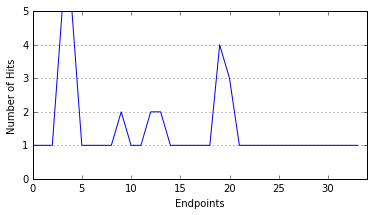

In [31]:
import pylab as plt
%matplotlib inline
endpoints = (access_logs
             .map(lambda log: (log.endpoint, 1))
             .reduceByKey(lambda a, b : a + b)
             .cache())
ends = endpoints.map(lambda (x, y): x).collect()
counts = endpoints.map(lambda (x, y): y).collect()

plt.figure(figsize=(6,3), facecolor='white')
plt.axis([0, len(ends), 0, max(counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(counts)


In [32]:
# Top Endpoints
endpointCounts = (access_logs
                  .map(lambda log: (log.endpoint, 1))
                  .reduceByKey(lambda a, b : a + b))

topEndpoints = endpointCounts.takeOrdered(10, lambda s: -1 * s[1])

print 'Top Ten Endpoints: %s' % topEndpoints

Top Ten Endpoints: [(u'/images/NASA-logosmall.gif', 5), (u'/shuttle/countdown/', 5), (u'/shuttle/countdown/count.gif', 4), (u'/images/KSC-logosmall.gif', 3), (u'/', 2), (u'/images/ksclogo-medium.gif', 2), (u'/shuttle/missions/sts-71/sts-71-patch-small.gif', 2), (u'/history/apollo/', 1), (u'/software/winvn/bluemarb.gif', 1), (u'/images/WORLD-logosmall.gif', 1)]


In [33]:
# top10 error endpoints

not200 = access_logs.filter(lambda log: log.response_code <> 200)

endpointCountPairTuple = not200.map(lambda log : (log.endpoint,1))

endpointSum = endpointCountPairTuple.reduceByKey(lambda v1,v2 : v1 + v2)

topTenErrURLs = endpointSum.takeOrdered(10, lambda s : -1 *s[1])
print 'Top Ten failed URLs: %s' % topTenErrURLs

Top Ten failed URLs: [(u'/images/ksclogo-medium.gif', 1), (u'/images/NASA-logosmall.gif', 1), (u'/cgi-bin/imagemap/countdown?99,176', 1), (u'/shuttle/countdown/liftoff.html', 1)]


In [34]:
# number of unique hosts

hosts = access_logs.map(lambda log : log.host)
uniqueHosts = hosts.distinct()
uniqueHostCount = uniqueHosts.count()
print 'Unique hosts: %d' % uniqueHostCount

Unique hosts: 23
